## INT IDS Long-slit Spectroscopy Reduction

This pipeline performs all the basic CCD data reduction. The steps are as follows:
- create a master bias frame
- create a master lamp flat frame
- create a master sky flat frame

- reduce individual science frames. Perform gain correction, bias subtraction, flat fielding and sky subtraction
- median combine reduced science frames into a deep spectrum

- reduce arc frames for wavelength calibration

- wavelength calibrate the 2D science spectrum
- extract and save 1D spectrum from a given position and aperture size. This feature requires the python package mpdaf. This can be downloaded using `pip install mpdaf` for python2 or `pip3 install mpdaf` for python3.

To add: flux calibration

The following reduction code works directly from the full set of images in a given night's observations. As observations are added during the evening, the ImageFileCollection object defined at the beginning needs to be refreshed.

ftp where frames are stored: rsync -av intobs@intdrpc1:/obsdata/inta/20190405/ .

In [2]:
### Import all relevant packages.
import warnings
import numpy as np

from multiprocessing import Pool
from functools import partial
import os

import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip, mad_std
from astropy.convolution import convolve, Gaussian2DKernel

from scipy.ndimage import binary_dilation
from astropy.utils.console import ProgressBar
import ccdproc
from ccdproc import ImageFileCollection, CCDData
from astropy.stats import sigma_clipped_stats
import scipy.optimize as optimize

import glob

import scipy
import matplotlib.pyplot as plt

from mpdaf.obj import Spectrum, WaveCoord

In [3]:
### Define functions relevant for calibration

def fit_chebyshev(row, degree=7, grow=3):
    """
    Fit Chebyshev1D model to a CCD row, including masking of outlier pixels
    
    Params
    ------
    row : array,
        Input CCD row to fit polynomial to.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    """

    fitter = fitting.LinearLSQFitter()
    input_mask = row.mask
    clipped = sigma_clip(row, stdfunc=mad_std)
    clipped_pixels = np.array(clipped.mask+row.mask).astype('float')
    clipped_pixels = binary_dilation(clipped_pixels, iterations=grow)

    row[clipped_pixels==1] = np.median(row)
    masked_row = np.ma.array(data=row, 
                             mask=(clipped_pixels == 1), 
                             fill_value=np.median(row))
    x = np.arange(len(row))
    model = models.Chebyshev1D(degree=degree)
    fitted_model = fitter(model, x, row)
    return fitted_model(np.arange(len(row)))


def fit_background(data, degree=7, grow=3, verbose=True, njobs=2):
    """
    Parallelised background estimation for longslit CCD image
    
    Params
    ------
    data : array,
        Input CCD data for background estimation.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    njobs : int
        Number of processes to initiate for fitting
    """
    kwargs={'degree': degree, 'grow': grow}    
    p = Pool(njobs)
    fitted_sky = p.map(partial(fit_chebyshev, **kwargs), data)
    p.close()
    return np.array(fitted_sky).astype('float')


### Edit the primary HDU and save

def edit_header(filename):
    hdulist = fits.open(filename)
    hdr = hdulist[0].header
    
    try:
        hdulist[0]
        hdulist.writeto(filename, overwrite=True)
    except KeyError:
        print("Keyword not found!")
        
        
### Dispersion functions wavelength calibration
def wavesol(x, m, c):
    return m*x + c

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    

In [4]:
### Select observing night, the working directory and create the relevant folders

obs_night = "20190407"

### Directory with all the raw files from an observing night
workdir = "/Users/aayushsaxena/Desktop/phd/HzQ_2019/Data/%s/" %obs_night

os.chdir(workdir)

try:
    os.mkdir("processed/")
except OSError:
    pass


In [5]:
### Load in all the files from the observing night

### For non-standard keyword in the header, run the edit_header function below. 
### If no error is flagged by ic1 then this function is not required

# filenames = glob.glob("*.fit")
# for file in filenames:
#     edit_header(file)


ic1 = ImageFileCollection(workdir)
ic1.summary

file,simple,bitpix,naxis,extend,run,irafname,runset,sysver,origin,observat,observer,proposal,object,obstype,imagetyp,latitude,longitud,height,slatel,telescop,telstat,ra,dec,equinox,radecsys,utobs,xapnom,yapnom,xapoff,yapoff,raoff,decoff,mjd-obs,jd,ststart,st,azstart,azend,zdstart,zdend,fstation,platesca,telfocus,actelfoc,rottrack,rotskypa,mntpasta,mntpaend,paransta,paranend,vignette,dazstart,dazend,airmass,amstart,amend,temptube,focustmp,focusalt,focusflt,autox,autoy,automode,cat-name,cat-ra,cat-dec,cat-equi,cat-epoc,pm-ra,pm-dec,parallax,radvel,ratrack,dectrack,agtvposx,agtvposy,agtvfilt,agtvshut,agposx,agposy,asndfilt,ascfilt,agarclmp,compmpos,autofilt,agcfilna,agcfilnb,instrume,camera,slitwid,pslitwid,sltwdsky,dekkerid,dekpos,bscfilt,bsndfilt,collname,collfoc,hartmanr,hartmanl,gratname,glinesmm,gratblaz,gratangl,gratshut,cenwave,detector,ccdspeed,ccdxbin,ccdybin,ccdsum,ccdtemp,ccdtemp1,ccdtemp2,nwindows,winsec1,winsec2,winsec3,winsec4,readmode,stormode,numreads,coaverag,date-obs,ut,utstart,ut-mid,exposed,exptime,elapsed,darktime,reqtime,dispaxis,comment
str12,bool,int64,int64,bool,int64,str8,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str8,str4,int64,int64,str3,float64,float64,float64,int64,str26,str19,str19,str19,str6,str6,int64,int64,str10,str12,str12,str12,float64,float64,float64,float64,float64,int64,object
r1452838.fit,True,8,0,True,1452838,r1452838,1:1:1452838,S1-27,ING La Palma,LAPALMA,Wagenveld,N17,P144+50,TARGET,object,28.761949,-17.877583,2348,LPO2.5,INT,GUIDING,14:41:28.720,+50:22:39.50,2000.0,FK5,3:43:42.8,0.0,0.0,0.0,0.0,0.0,0.0,58580.1553566,2458580.6553566,15:32:43.6,15:32:43.6,339.626949,330.359885,23.541904,26.349727,CASSEGRAIN,1.502645,0.015507,0.015389,True,59.58821,59.58821,59.598209,151.060084,136.970387,False,344.49018,330.080448,1.10232,1.090753,1.115949,3.00221,-0.117938,0.0,0.0,233.16,128.07,AUTOGUIDE,P144+50,14:41:28.720,+50:22:39.50,J2000.00,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497796,0.499998,F0 Clear,OPEN,0.535168,0.410619,F0 Clear,F0 Clear,,OUT,F0 Clear,F0 Clear,F0 Clear,IDS,235,0.000275,0.046,1.488,D-CORO,P0 Clear,F0 Clear,F0 empty,Al-wide,217,OPEN,OPEN,R400R,400,7250.0,62.9,OPEN,7505.571,REDPLUS2,SLOW,1,1,1 1,155.655,0.0,0.0,0,"[0:0,0:0], disabled","[0:0,0:0], disabled","[0:0,0:0], disabled","[0:0,0:0], disabled",simple,normal,1,1,2019-04-07,03:43:43.198,03:43:43.198,03:58:43.203,1800.01,1800.01,1800.15883995,1800.15883995,1800.0,2,--
r1452839.fit,True,8,0,True,1452839,r1452839,1:1:1452839,S1-27,ING La Palma,LAPALMA,Wagenveld,N17,P144+50,TARGET,object,28.761949,-17.877583,2348,LPO2.5,INT,GUIDING,14:41:28.719,+50:22:39.55,2000.0,FK5,4:14:33.8,0.0,0.0,0.0,0.0,0.0,0.0,58580.1767802,2458580.6767802,16:03:39.7,16:03:39.7,330.135609,323.469317,26.442474,30.070301,CASSEGRAIN,1.502645,0.015507,0.015389,True,59.598209,59.598209,59.598209,136.608114,125.016504,False,330.080448,323.049124,1.135023,1.116846,1.155524,2.965412,-0.117938,0.0,0.0,233.16,128.07,AUTOGUIDE,P144+50,14:41:28.720,+50:22:39.50,J2000.00,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497796,0.499998,F0 Clear,OPEN,0.535168,0.410619,F0 Clear,F0 Clear,,OUT,F0 Clear,F0 Clear,F0 Clear,IDS,235,0.000275,0.046,1.488,D-CORO,P0 Clear,F0 Clear,F0 empty,Al-wide,218,OPEN,OPEN,R400R,400,7250.0,62.9,OPEN,7505.571,REDPLUS2,SLOW,1,1,1 1,155.655,0.0,0.0,0,"[0:0,0:0], disabled","[0:0,0:0], disabled","[0:0,0:0], disabled","[0:0

## Create/read biases

In [6]:
### Run this the first time to create master bias frames

try:
    os.mkdir("processed/BIAS/")
except OSError:
    pass

### Create red master bias
# red_bias_list = []

# for filename in ic1.files_filtered(obstype='BIAS', object='Bias'):
#     ccd = CCDData.read(ic1.location + filename, unit = u.adu)
#     #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
#     #                               readnoise=ccd.header['READNOIS']*u.electron)
#     #this has to be fixed as the bias section does not include the whole section that will be trimmed
#     ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
#     ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
#     red_bias_list.append(ccd)

# master_bias = ccdproc.combine(red_bias_list, method='median')
# master_bias.write('./processed/BIAS/master_bias.fits', overwrite=True)

### uncomment the following line once master bias created to simply load in the relevant bias
master_bias = CCDData.read('./processed/BIAS/master_bias.fits', unit=u.adu)

print("Master Bias created")

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Master Bias created


## Create/read flats

### Lamp flats
These are taken as part of the afternoon calibrations with complamps W

In [7]:
### Lamp flats

try:
    os.mkdir("processed/FLAT/")
except OSError:
    pass

kernel = Gaussian2DKernel(25)

# red_flat_list = []
# for filename in ic1.files_filtered(obstype='FLAT'):
#     ccd = CCDData.read(ic1.location + filename, unit = u.adu)
#     #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
#      #                              readnoise=ccd.header['READNOIS']*u.electron)
#     #this has to be fixed as the bias section does not include the whole section that will be trimmed
#     ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
#     ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
#     ccd = ccdproc.subtract_bias(ccd, master_bias)    
#     red_flat_list.append(ccd)

# master_flat = ccdproc.combine(red_flat_list, method='median')
# convolved_flat = convolve(master_flat.data, kernel, boundary='extend')

# master_flat.write('./processed/FLAT/master_flat.fits', overwrite=True)

# master_flat.data /= convolved_flat
# master_flat.write('./processed/FLAT/master_flat_norm.fits', overwrite=True)

### Uncomment the following line once master flats have been created
master_flat_red = CCDData.read('./processed/FLAT/master_flat.fits')

print("Master flat created")

Master flat created


### Sky flats
These are taken around sunset (or sunrise). They have absorption lines but are superior to lamp flats as they give a more accurate flat-fielding for the science exposures. Give these priority. If for some reason sky flats were not taken, lamp flats should work too.

In [8]:
### Sky flats

try:
    os.mkdir("processed/FLAT/")
except OSError:
    pass

# skyflat_list = []
# for filename in ic1.files_filtered(obstype='SKY'):
#     ccd = CCDData.read(ic1.location + filename, unit = u.adu)
#     #ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
#      #                              readnoise=ccd.header['READNOIS']*u.electron)
#     #this has to be fixed as the bias section does not include the whole section that will be trimmed
#     ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
#     ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
#     ccd = ccdproc.subtract_bias(ccd, master_bias)    
#     skyflat_list.append(ccd)

# master_skyflat = ccdproc.combine(skyflat_list, method='median')
# convolved_skyflat = convolve(master_skyflat.data, kernel, boundary='extend')

# master_skyflat.write('./processed/FLAT/master_skyflat.fits', overwrite=True)

# master_skyflat_norm.data /= convolved_flat
# master_skyflat_norm.write('./processed/FLAT/master_skyflat_norm.fits', overwrite=True)

### Uncomment the following line once master flats have been created
master_skyflat = CCDData.read('./processed/FLAT/master_skyflat.fits')

print("Master sky flat created")

Master sky flat created


# Reduce science data

In [25]:
#######################
objects = ["M101"] # Enter object name(s) (see from observing log)
#######################

try:
    os.mkdir("processed/SCI/")
except OSError:
    pass

### Ignore masked array warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Refresh the file list to include new exposures
ic1 = ImageFileCollection(workdir)
    
### Reduce science frame
for objname in objects:
    print("Reducing:", objname)
    target_list = []
    for ifx, filename in enumerate(ic1.files_filtered(obstype='TARGET', object=objname)):
        print('{0} {1}'.format(ifx+1, filename))
        hdu = fits.open(ic1.location + filename)
        ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
        #this has to be fixed as the bias section does not include the whole section that will be trimmed

        ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4., niter=10, sigfrac=0.3, psffwhm=2.5, 
                                         gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])
        ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
        ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
        ccd = ccdproc.subtract_bias(ccd, master_bias)
        ccd = ccdproc.flat_correct(ccd, master_skyflat)


        # Do sky subtraction
        ccd.mask[:,690:700] = True
        sky = fit_background(np.ma.array(ccd.data, mask=ccd.mask))
        ccd.data -= sky

        # Rotate Frame

        ccd.data = ccd.data.T
        ccd.mask = ccd.mask.T
        #ccd.write('obj_'+filename, overwrite=True)
        target_list.append(ccd)

    red_target = ccdproc.combine(target_list, method='median')
    # red_target.write('{0}_red.fits'.format(red_target_list[0].header['object']), overwrite=True)

#         red_target.mask[785:800,:] = True
#         red_sky = fit_background(np.ma.array(red_target.data.T, mask=red_target.mask.T)).T
#         red_target.data -= red_sky

    red_target.write('./processed/SCI/{0}.fits'.format(target_list[0].header['object']), overwrite=True)

    print("Reduced object")

Reducing: M101
1 r1452904.fit
Reduced object


In [201]:
## OPTIONAL: Trim the final spectrum when CCD window is not applied.
## This does not need to be executed under normal circumstances!

hdulist = fits.open("processed/SCI/P144+50.fits")
hdr = hdulist[0].header
    
hdulist[0].data = hdulist[0].data[800:1165,1:4200]

hdulist.writeto("processed/SCI/P144+50_trimmed.fits", overwrite=True)
hdulist.close()

# Wavelength calibration

## Reduce arc frames 
Start by reducing the arc frames. This command can either be run after relevant arcs to the science object have been taken, or all at once towards the end of the night to reduce all arcs.

In [27]:
try:
    os.mkdir("processed/ARCS/")
except OSError:
    pass


ic1 = ImageFileCollection(workdir)

for filename in ic1.files_filtered(obstype='Arc'):
    hdu = fits.open(ic1.location + filename)
    ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    ccd = ccdproc.subtract_bias(ccd, master_bias)
    ccd = ccdproc.flat_correct(ccd, master_skyflat)
    ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4.5, gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])

    ccd.data = ccd.data.T
    ccd.mask = ccd.mask.T
    ccd.write('./processed/ARCS/arc_'+filename, overwrite=True)

## Wavelength calibration

In [28]:
### Select target and the relevant arc - check the log

target = "M101"
red_arc = fits.getdata('./processed/ARCS/arc_r1452900.fit')

<IPython.core.display.Javascript object>


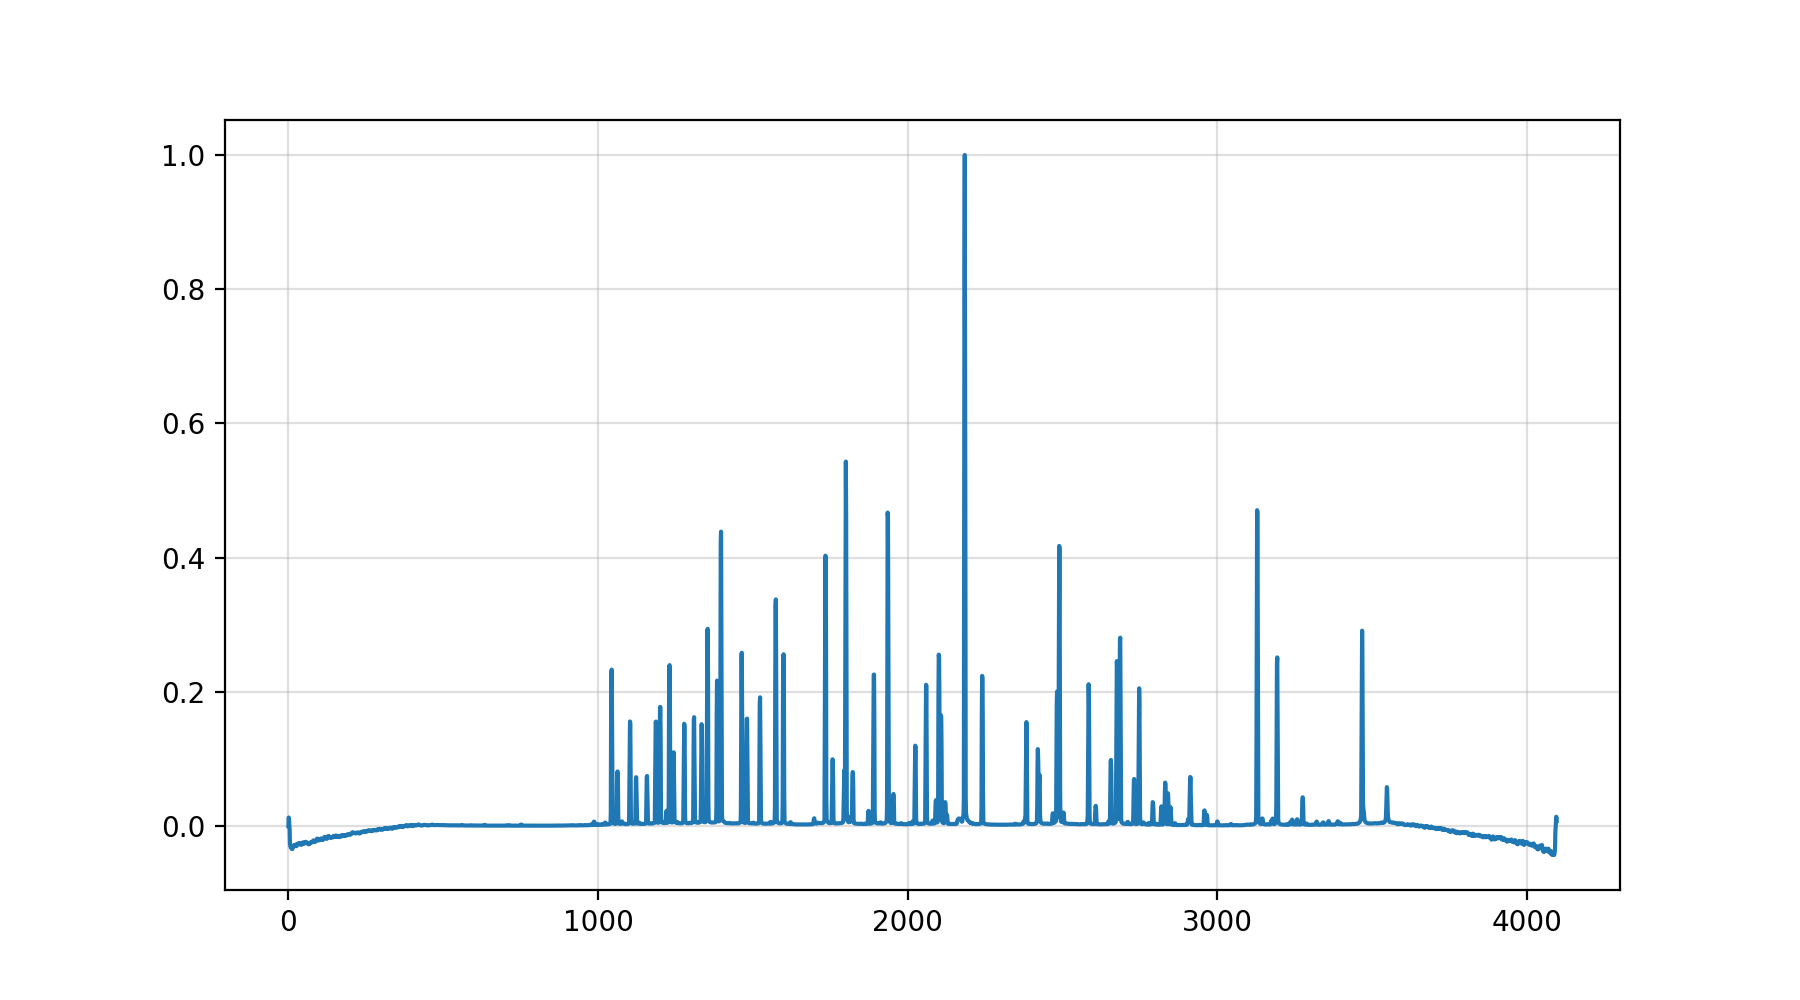

In [29]:
### normalise the arc spectrum
mean_red_arc = np.median(red_arc[:,:], axis=0)

## normalise the arc lines
maxval = np.max(mean_red_arc)
red_arc_normed = mean_red_arc/maxval

%matplotlib notebook

fig = plt.figure(figsize=(9,5))
plt.plot(red_arc_normed)

plt.grid(alpha=0.4)
plt.show()

<IPython.core.display.Javascript object>


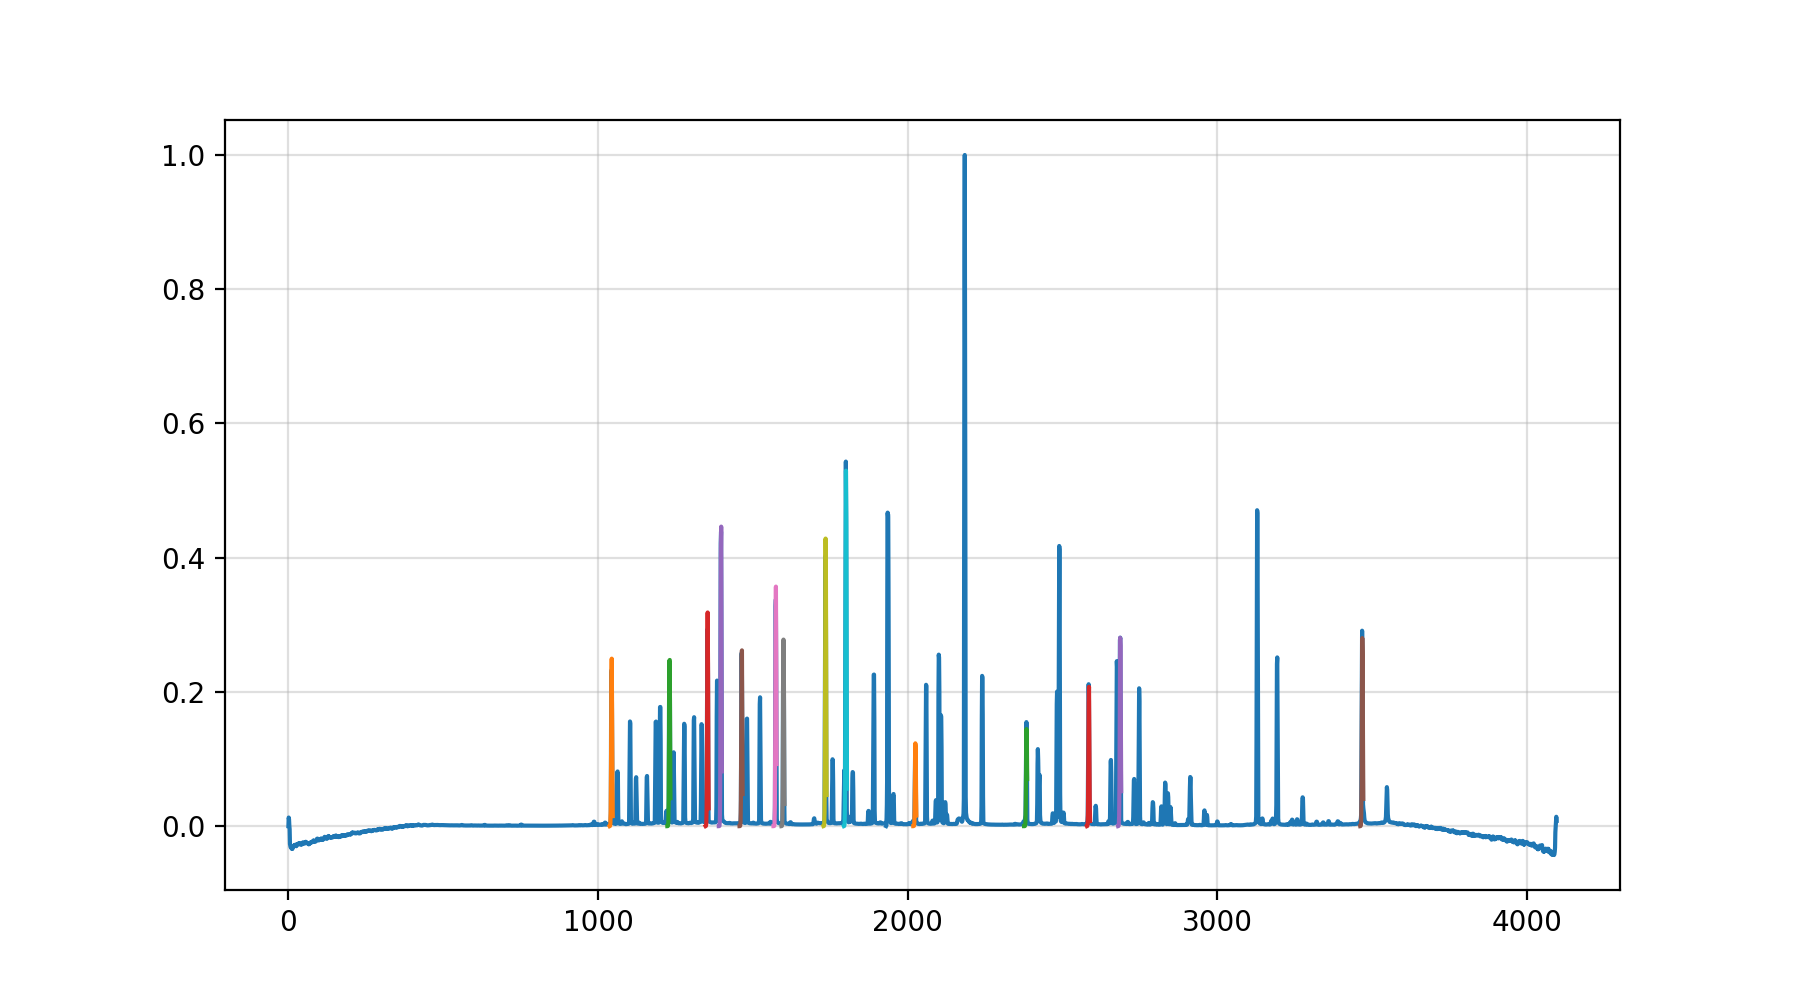

In [30]:
# Lines for the red arc
pixels_red = [1042.33, 1228.61, 1352.1, 1394.7, 1461.7, 1571.4, 1596.94,
              1732.9, 1798.7, 1935.0, 2022.74, 
              2380.47, 2583.5, 2684.1, 3465.9]

wavelengths_red = [5852.49, 6143.06, 6334.43, 6402.25, 6506.53, 6678.3, 6717.04,
                   6929.47, 7032.41, 7245.17, 7383.98, 
                   7948.17, 8264.52, 8424.65, 9122.97]


# Create x axis
xaxis = np.linspace(0,4200, 4200)

%matplotlib notebook

fig = plt.figure(figsize=(9,5))
plt.grid(alpha=0.4)
plt.plot(red_arc_normed)

line_pix = []

for pixel in pixels_red:
    # create gaussian to fit to the arc line
    p0 = [0.4, pixel, 3.0]
    coeffs, covar = optimize.curve_fit(gauss, xaxis[int(pixel)-10:int(pixel+12)], red_arc_normed[int(pixel)-10:int(pixel+12)], p0=p0, 
                                       bounds=([0.05, pixel-5, 1.0], [1.0, pixel+5, 6.0]))
    line_pix.append(coeffs[1])
    plt.plot(np.linspace(pixel-5, pixel+5, 10), gauss(np.linspace(pixel-5, pixel+5, 10), *coeffs))
    
    
sol_red = []
for i in range(len(wavelengths_red)):
    sol_red.append(wavelengths_red[i]-line_pix[i])

plt.grid(alpha=0.4)
plt.show()

# %matplotlib notebook
# plt.plot(line_pix, wavelengths_red)

[1.42748872e+00 4.44093021e+03]


<IPython.core.display.Javascript object>


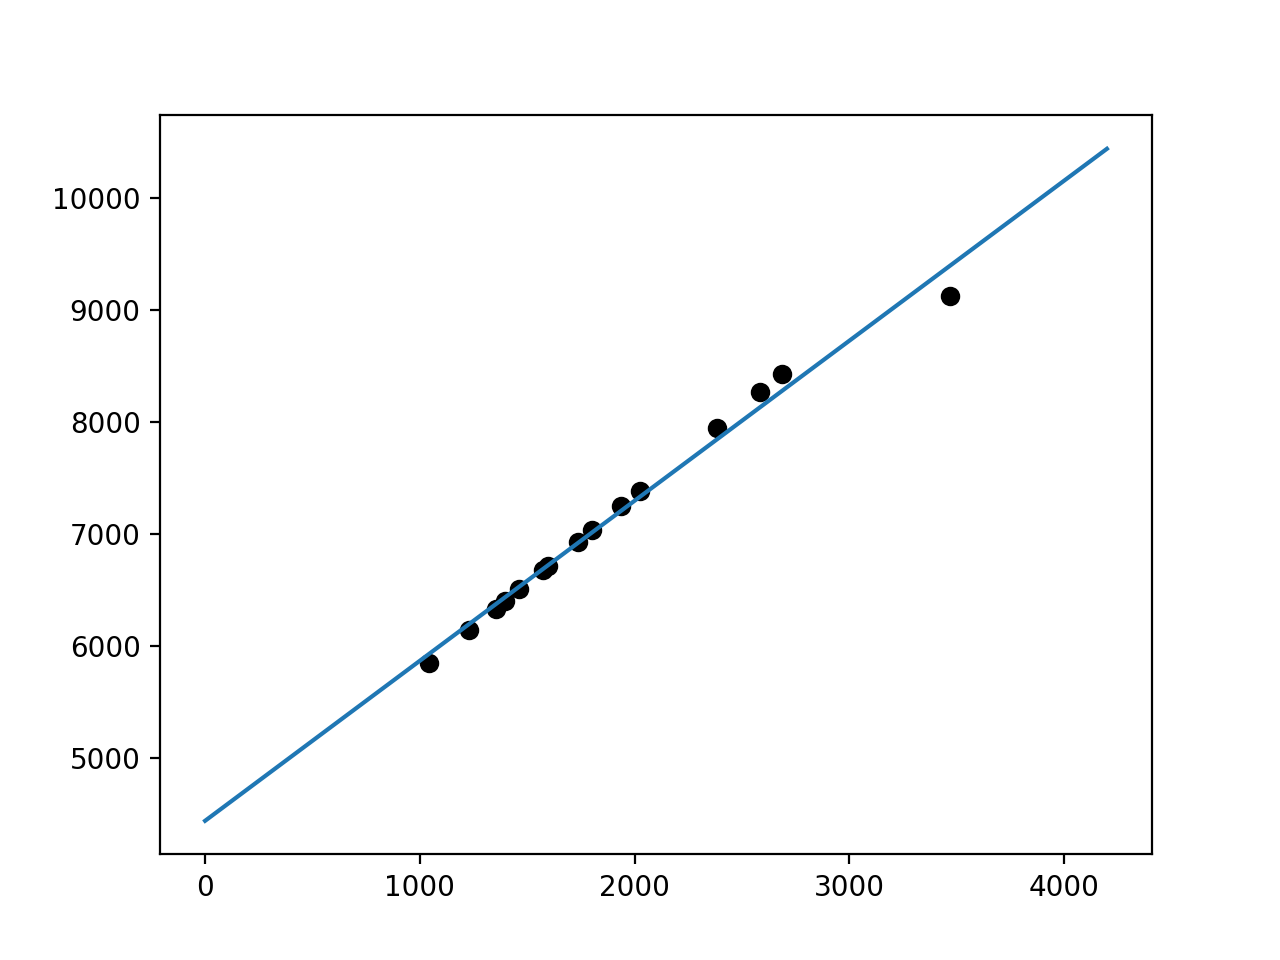

In [31]:
# Lets try and find a wavelength calibration solution
# Fit Red wavelength solutions

# initial guess
p0 = [3, 4000]

fit_red, cov_red = optimize.curve_fit(wavesol, line_pix, wavelengths_red, p0=p0)

print(fit_red)

wavered = wavesol(xaxis, *fit_red)

%matplotlib notebook

plt.plot(line_pix, wavelengths_red, 'ko')
plt.plot(xaxis, wavered)

plt.show()

In [32]:
### Calculate CRPIX and CRDELT values based on new wavelength range and then update the header of the SCI file
# print(len(wavered))
# print(wavered[0], max(wavered))

crval1 = wavered[0]
cdelt1 = (wavered[-1]-wavered[0])/len(wavered)
cunit1 = 'Angstrom'

print(crval1, cdelt1, cunit1)

## Update sci file

scidata, scihead = fits.getdata("./processed/SCI/%s.fits" %target, header=True)

scihead['CRVAL1'] = crval1
scihead['CRVAL2'] = 1.0
scihead['CDELT1'] = cdelt1
scihead['CRPIX2'] = 135.0
scihead['CUNIT1'] = cunit1
scihead['CUNIT2'] = 'Arcsec'
scihead['CTYPE1'] = 'LINEAR'
scihead['CTYPE2'] = 'LINEAR'
scihead['CD1_1'] = cdelt1
scihead['CD2_2'] = 0.44
scihead['PV2_1'] = 1.0

fits.writeto("./processed/SCI/%s_WC.fits" %target, scidata, header=scihead, overwrite=True)

print("Wavelength calibration complete.")

4440.93021018045 1.4274887152983289 Angstrom
Wavelength calibration complete.


## Extraction of 1D spectrum from 2D

Import the WC 2D spectrum and extract a 1D spectrum using an aperture. We will save the output spectrum as an MPDAF Spectrum object

<IPython.core.display.Javascript object>


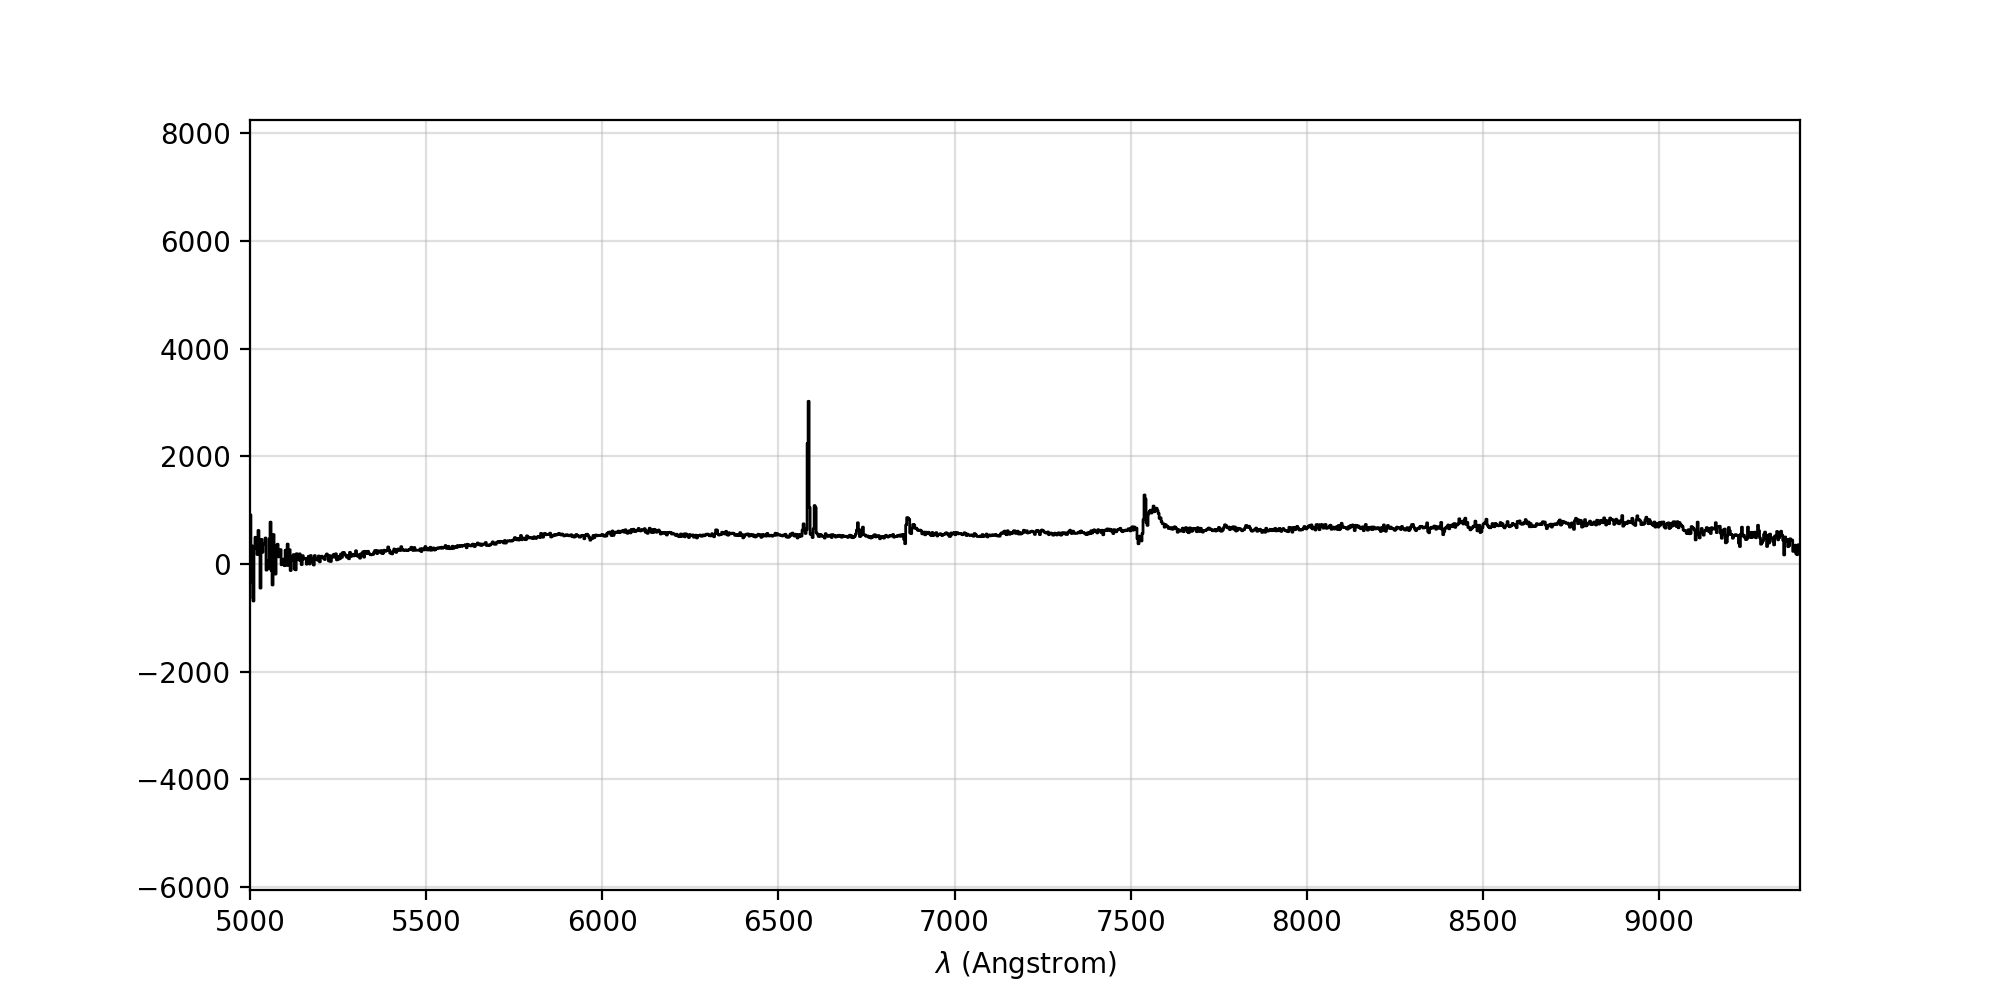

1D spectrum extracted


In [52]:
## Read in the 2D spectrum

spec2d, spechead = fits.getdata("./processed/SCI/%s_WC.fits" %target, header=True)

## Read in the wavelength axis values
cdelt = spechead['CDELT1']
crval = spechead['CRVAL1']

wavelength_1d = WaveCoord(cdelt=cdelt, crval=crval, cunit=u.Angstrom)

central_pix = 186
aperture = 15

spectrum_1d = np.sum(spec2d[central_pix-aperture:central_pix+aperture,:], axis=0)
# print(np.shape(spectrum_1d))

spectrum_mpdaf_b = Spectrum(wave=wavelength_1d, data=spectrum_1d, data_header=spechead)

%matplotlib notebook
fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

spectrum_mpdaf_b.rebin(2).plot(color='k')
plt.xlim(5000, 9400)
# plt.ylim(-7,50)

### Show lines
# z = 0.00328
# plt.axvline(6548.0*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(6562.8*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(6583.46*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(6716.4*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(6730.810*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(7452.538*(1+z), color='k', ls='--', alpha=0.5)



# plt.savefig("./processed/SCI/M101_1D.png", overwrite=True)

plt.show()

spectrum_mpdaf_b.write("./processed/SCI/%s_1D.fits" %target)

print("1D spectrum extracted")

## To include: flux calibration